<p align="center">
<h1>Signals and systems</h1>
<h2>Project documentation</h2>
Author: Denis Dzíbela xdzibe00
</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, fft, signal
from scipy.io import wavfile

## Input preprocessing

### File input

We use ```scipy.io.wavfile.read()``` to obtain the raw signal, and the frequency at which it was sampled, the signal has a high dynamic range and may have a DC bias, we take care of this in the following step.

Sampling rate: 16000Hz
Audio length:
               53556 samples
               3.34725 seconds
Max value:     2635
Min value:     -1516


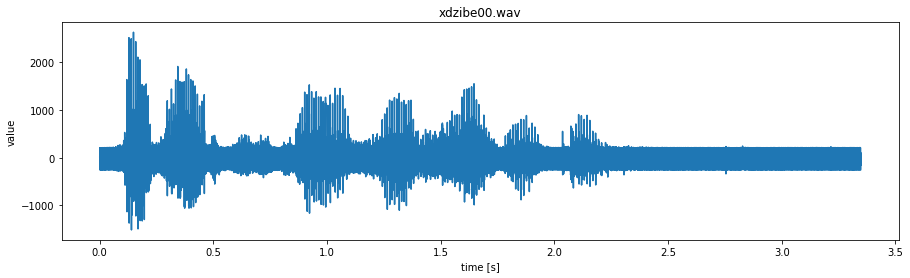

In [2]:
samplingRate, rawData = io.wavfile.read('../audio/xdzibe00.wav')

#Get info about our signal
print('Sampling rate: ' + str(samplingRate) + 'Hz')
print('Audio length:')
print('               ' + str(rawData.size) + ' samples')
print('               ' + str(rawData.size / samplingRate) + ' seconds')
print('Max value:     ' + str(rawData.max()))
print('Min value:     ' + str(rawData.min()))

#Plotting our signal
plt.figure(1, figsize=(15,4))
plt.title('xdzibe00.wav')
plt.xlabel('time [s]')
plt.ylabel('value')
Time = np.linspace(0, len(rawData) / samplingRate, num=len(rawData))
plt.plot(Time, rawData)
plt.show()

### Normalization and segmentation

To be able to work with our signal more easily we will get rid of the DC bias and normalize the dynamic range from +1 to -1 .

For the purpose of calculating the discrete Fourier transform of our signal we split it into 104 frames, each 1024 samples long, with 512 samples overlap between frames, discarding the 105th frame as it is incomplete.

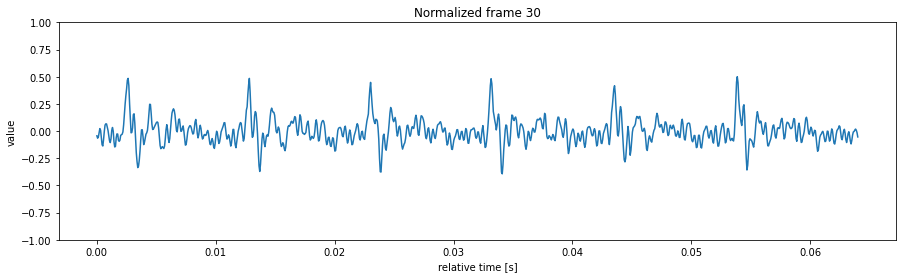

In [3]:
#remove DC bias
rawData -= int(np.mean(rawData))
#normalize the data
normData = rawData / np.abs(rawData).max()

#slice into 1024 sample long frames, with 512 sample overlap
slicedData = np.zeros(shape=(int(normData.size / 512),1024))
for i in range(0, int(normData.size / 512) - 1): #the last frame would be incomplete so we ignore it
    slicedData[i] = normData[i * 512:(i * 512) + 1024]

#Plot a selected frame
plt.figure(2, figsize=(15,4))
plt.title('Normalized frame 30')
plt.xlabel('relative time [s]')
plt.ylabel('value')
plt.ylim(-1, +1)
Time = np.linspace(0, slicedData[30].size / samplingRate, num=slicedData[30].size)
plt.plot(Time, slicedData[30])
plt.show()

## Fourier transform


### Custom implementation

### Comparison with a library implementation

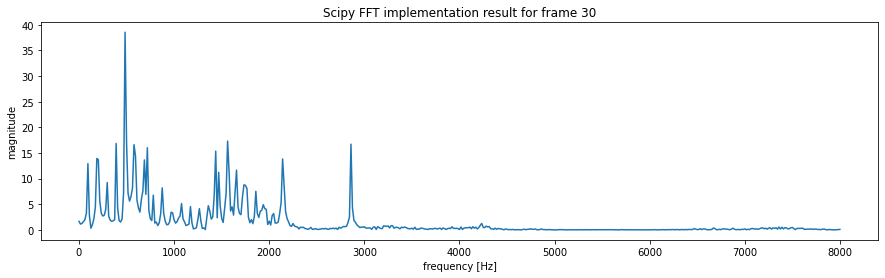

In [5]:
dftLibrary = np.zeros(shape=(slicedData.shape))
for i in range(0, dftLibrary.shape[0]):
    dftLibrary[i] = np.abs(fft.fft(slicedData[i]))

#Plot the results
plt.figure(4, figsize=(15,4))
plt.title('Scipy FFT implementation result for frame 30')
plt.xlabel('frequency [Hz]')
plt.ylabel('magnitude')
#Convert DFT coeficientf to frequencies
f = np.arange(dftLibrary[30].size) / 1024 * samplingRate
#We only want to plot up to samplingRate/2
plt.plot(f[:f.size//2+1], dftLibrary[30][:dftLibrary[30].size//2+1])
plt.show()

Looking at the spectrum of one frame we see isolated peaks at 2100Hz and 2800Hz, theese might be the frequencies we are looking for but we can not be sure from just one spectrum.

## Spectrum analysis

### Spectogram

We compute and show the signals power spectral density to more precisely identify the disrupting frequecies.

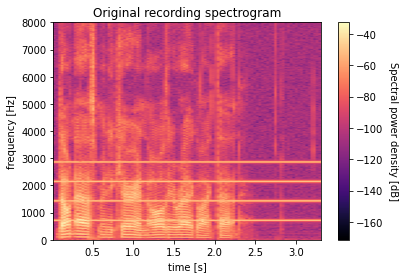

In [6]:
plt.figure(5)
plt.title('Original recording spectrogram')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.specgram(normData, 1024, noverlap=512, Fs=samplingRate, cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Spectral power density [dB]', rotation=270, labelpad=15)

From the spectrogram we identify the 4 disrupting frequencies by the 4 bright lines at 700Hz, 1400Hz, 2100Hz and 2800Hz.

### Rogue signal generation

We shall confirm that we have detected the right frequencies by generating our own signal and comparing it with the original.

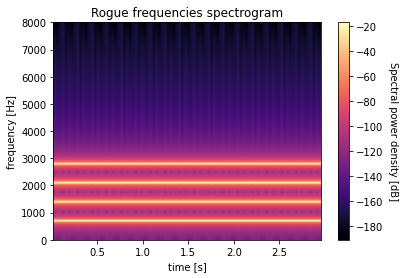

In [7]:
#Create a 0 valued signal 3 seconds long
rogueCosines = np.zeros(3 * samplingRate)

#Add the rogue frequencies
n = np.linspace(0, 3, 3 * samplingRate, False)
rogueCosines += np.cos(2 * np.pi * 700 * n)
rogueCosines += np.cos(2 * np.pi * 1400 * n)
rogueCosines += np.cos(2 * np.pi * 2100 * n)
rogueCosines += np.cos(2 * np.pi * 2800 * n)

#Write the result to file
io.wavfile.write('../audio/4cos.wav', samplingRate, rogueCosines)

#Plot the spectrum
plt.figure(6)
plt.title('Rogue frequencies spectrogram')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.specgram(rogueCosines, 1024, noverlap=512, Fs=samplingRate, cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Spectral power density [dB]', rotation=270, labelpad=15)

By listening and visual comparison of the two signals' spectrograms we confirm that we have found the correct frequencies.

## Filtration

### Filter design

Filter design was chosen as 4 Butterworth bandstop filters centered on the 4 disrupting frequencies.

We call ```scipy.signal.buttord()``` to get the minimal order of our filters and then construct them using ```scipy.signal.butter()```

In [8]:
#Get Butterworth filter order
ord, wn = signal.buttord(wp=[0.1, 0.6], ws=[0.2, 0.5], gpass=3, gstop=40, fs=samplingRate)

#Construct our four filters, some hand tweaking of the frequency bands was needed
sos = [0,0,0,0]
sos[0] = signal.butter(ord, [700 - 55, 700 + 55], 'bandstop', fs=samplingRate, output='sos')
sos[1] = signal.butter(ord, [1400 -55, 1400 +55], 'bandstop', fs=samplingRate, output='sos')
sos[2] = signal.butter(ord, [2100 -75, 2100 +70], 'bandstop', fs=samplingRate, output='sos')
sos[3] = signal.butter(ord, [2800 -75, 2800 +90], 'bandstop', fs=samplingRate, output='sos')
print('Filter coeficients:')
print('Filter 1')
print(signal.butter(ord, [700 - 55, 700 + 55], 'bandstop', fs=samplingRate, output='ba'))
print('Filter 2')
print(signal.butter(ord, [1400 -55, 1400 +55], 'bandstop', fs=samplingRate, output='ba'))
print('Filter 3')
print(signal.butter(ord, [2100 -75, 2100 +70], 'bandstop', fs=samplingRate, output='ba'))
print('Filter 4')
print(signal.butter(ord, [2800 -75, 2800 +90], 'bandstop', fs=samplingRate, output='ba'))

Filter coeficients:
Filter 1
(array([ 7.91277084e-01, -2.58993790e+01,  4.12376641e+02, -4.25475967e+03,
        3.19708105e+04, -1.86423303e+05,  8.77717822e+05, -3.42791743e+06,
        1.13219793e+07, -3.20826331e+07,  7.88536290e+07, -1.69528812e+08,
        3.20909216e+08, -5.37576214e+08,  8.00008051e+08, -1.06066733e+09,
        1.25528081e+09, -1.32762036e+09,  1.25528081e+09, -1.06066733e+09,
        8.00008051e+08, -5.37576214e+08,  3.20909216e+08, -1.69528812e+08,
        7.88536290e+07, -3.20826331e+07,  1.13219793e+07, -3.42791743e+06,
        8.77717822e+05, -1.86423303e+05,  3.19708105e+04, -4.25475967e+03,
        4.12376641e+02, -2.58993790e+01,  7.91277084e-01]), array([ 1.00000000e+00, -3.22804191e+01,  5.06902595e+02, -5.15808411e+03,
        3.82254221e+04, -2.19829749e+05,  1.02077778e+06, -3.93186955e+06,
        1.28081388e+07, -3.57957181e+07,  8.67726130e+07, -1.83995396e+08,
        3.43518886e+08, -5.67565552e+08,  8.33068035e+08, -1.08937654e+09,
        1.

### Zeroes and poles

We can use ```scipy.signal.sos2zpk()``` to calculate the zeroes and poles of our 4 filters

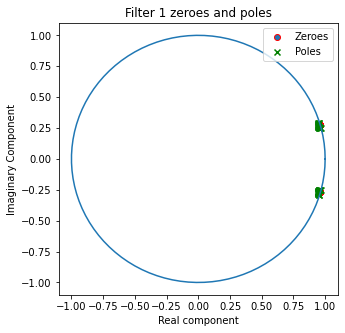

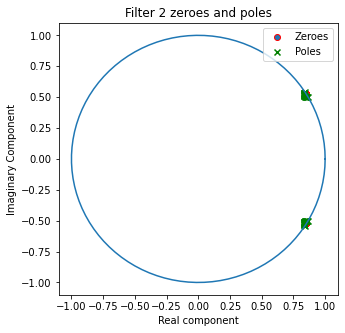

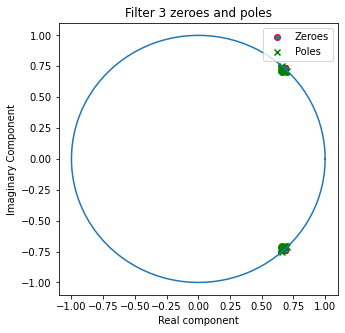

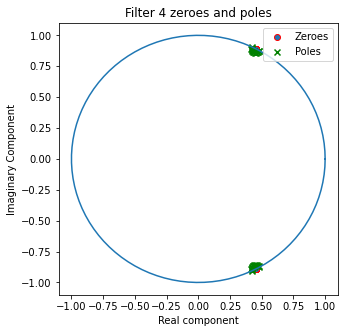

In [9]:
for i in range(0, 4):
    plt.figure(8 + i, figsize=(5,5))
    z, p, k = signal.sos2zpk(sos[i])
    plt.title('Filter ' + str(i + 1) + ' zeroes and poles')
    #Unit circle
    ang = np.linspace(0, 2*np.pi,100)
    plt.plot(np.cos(ang), np.sin(ang))
    #Zeroes
    plt.scatter(np.real(z), np.imag(z), marker='o', edgecolors='r', label='Zeroes')
    #Poles
    plt.scatter(np.real(p), np.imag(p), marker='x', facecolor='g', label='Poles')
    #Axis labels
    plt.xlabel('Real component')
    plt.ylabel('Imaginary Component')
    plt.legend(loc='upper right')
    plt.show()

### Impulse response

We can use the zeroes and poles with ```scipy.signal.impulse()``` to calculate the impulse response of the filters.

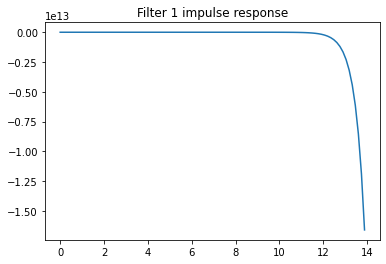

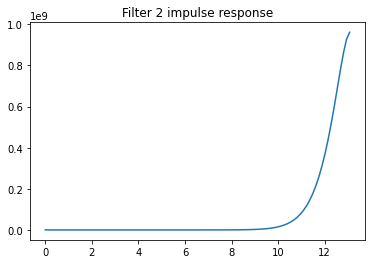

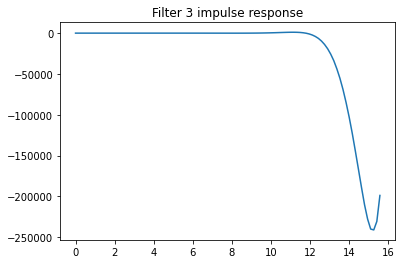

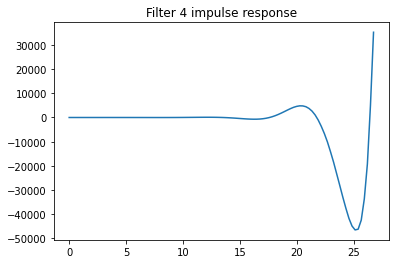

In [10]:
for i in range(0,4):
    plt.figure(11 + i)
    plt.title('Filter ' + str(i + 1) + ' impulse response')
    z, p, k = signal.sos2zpk(sos[i])
    t, yout = signal.impulse((z,p,k))
    plt.plot(t, yout)
    plt.show()

### Frequency characteristic

Likewise we call ```scipy.signal.sosfreqz()``` to get the frequency response of our filters

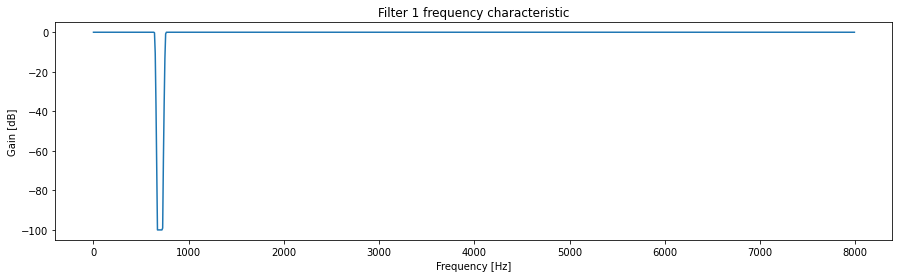

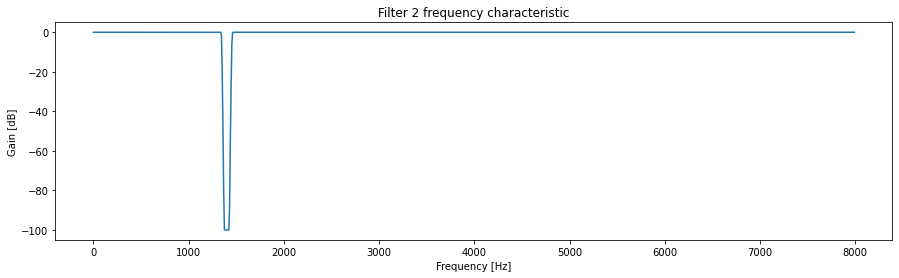

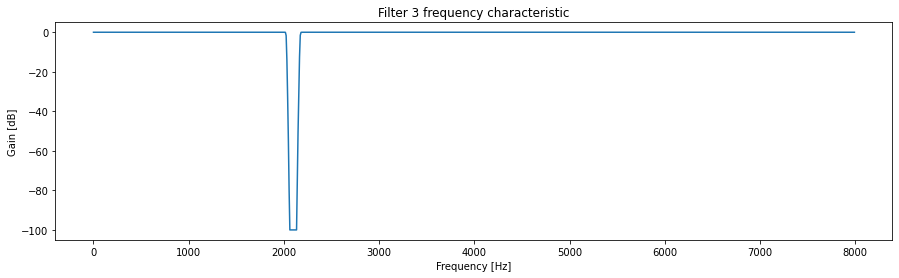

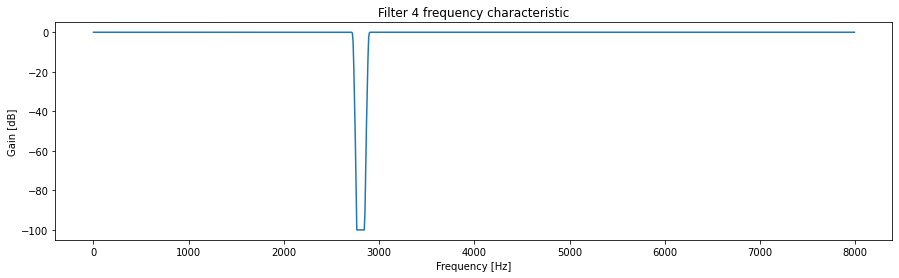

In [11]:
for i in range(0, 4):
    plt.figure(14 + i, figsize=(15,4))
    w, h = signal.sosfreqz(sos[i], worN=1024, fs=samplingRate)
    plt.title('Filter ' + str(i + 1) + ' frequency characteristic')

    db = 20*np.log10(np.maximum(np.abs(h), 1e-5))
    plt.plot(w, db)
    #Axis labels
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Gain [dB]')
    plt.show()

### Filtration

Lastly we apply the four filters to the normalized signal, the spectrogram shows that the filters had blocked only little of the actual signal, leaving us with a clean recording.

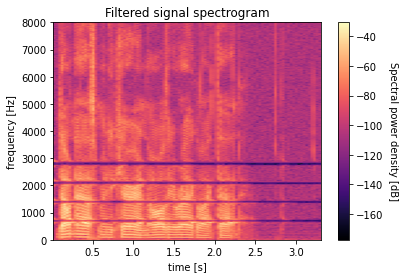

In [12]:
#Apply our four filters
filtered = signal.sosfilt(sos[0], normData)
for i in range(1,4):
    filtered = signal.sosfilt(sos[i], filtered)

#Save the result to file
io.wavfile.write('../audio/clean_bandstop.wav', samplingRate, filtered)

#Plot a spectrogram for good measure
plt.figure(666)
plt.title('Filtered signal spectrogram')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.specgram(filtered, 1024, noverlap=512, Fs=samplingRate, cmap='magma')
cbar = plt.colorbar()
cbar.set_label('Spectral power density [dB]', rotation=270, labelpad=15)